Импортируем библиотеки

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import warnings
from pprint import pprint
import datetime as dt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
import statsmodels.api as sm
from scipy.spatial.distance import cdist
from matplotlib.ticker import NullFormatter

Загружаем тренировочные датасеты с продажами и рекламными акциями и ознакомимся с ними

In [2]:
sales = pd.read_csv('sales_train.csv')
advert = pd.read_csv('advert_train.csv')
sales.head(3)

,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2008-01-02,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,2008-01-03,NaN,1.006943,1.002595,1.006953,1.014819,NaN,1.008989,1.003241
2,2008-01-04,1.015188,NaN,1.043535,1.044507,1.050865,1.025508,1.037337,1.024117


In [3]:
advert.head(3)

,date,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
0,2008-01-02,0,0,0,0,0,0,0,0
1,2008-01-03,0,0,0,0,0,0,0,0
2,2008-01-04,0,0,0,0,0,0,0,0


Проверим на пропуски наши данные

In [4]:
print(advert.isna().mean())
sales.isna().mean()

date        0.0
market_1    0.0
market_2    0.0
market_3    0.0
market_4    0.0
market_5    0.0
market_6    0.0
market_7    0.0
market_8    0.0
dtype: float64


date        0.000000
market_1    0.206436
market_2    0.205751
market_3    0.193769
market_4    0.205751
market_5    0.196508
market_6    0.212256
market_7    0.196166
market_8    0.188634
dtype: float64

В датасете с акциями пропусков нет, а вот в продажах имеется примерно по 20% пропусков для каждого магазина. Чтобы избавиться от пропусков сделаем интерполяцию.

In [5]:
sales = sales.interpolate()
sales.isnull().sum()

C:\Users\User\AppData\Local\Temp\ipykernel_14952\640145417.py:1: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  sales = sales.interpolate()


date        0
market_1    0
market_2    0
market_3    0
market_4    0
market_5    0
market_6    0
market_7    0
market_8    0
dtype: int64

Теперь изменим форму обоих датафреймов и соединим их в один

In [6]:
sales = sales.melt(id_vars='date', var_name='name_of_shop', value_name='sales').dropna()
advert = advert.melt(id_vars='date', var_name='name_of_shop', value_name='is_promotion')

df = pd.merge(sales, advert, on = ['date', 'name_of_shop'])
df['date'] = pd.to_datetime(df['date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23368 entries, 0 to 23367
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          23368 non-null  datetime64[ns]
 1   name_of_shop  23368 non-null  object        
 2   sales         23368 non-null  float64       
 3   is_promotion  23368 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 730.4+ KB


Сделаем еще некоторые преобразования.

In [7]:
df["day_of_the_week"] = df['date'].dt.day_name()
df["month"] = df['date'].dt.month
df["year"] = df['date'].dt.year
df["day"] = df['date'].dt.day
df.head()

,date,name_of_shop,sales,is_promotion,day_of_the_week,month,year,day
0,2008-01-02,market_1,1.000000,0,Wednesday,1,2008,2
1,2008-01-03,market_1,1.007594,0,Thursday,1,2008,3
2,2008-01-04,market_1,1.015188,0,Friday,1,2008,4
3,2008-01-05,market_1,1.005475,0,Saturday,1,2008,5
4,2008-01-06,market_1,0.995762,0,Sunday,1,2008,6


In [8]:
dummies = pd.get_dummies(df['day_of_the_week']).rename(columns = lambda x: 'is_' + str(x))
df = pd.concat([df, dummies], axis = 1)
df.drop('day_of_the_week', axis=1, inplace=True)
df.head()

,date,name_of_shop,sales,is_promotion,month,year,day,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday
0,2008-01-02,market_1,1.000000,0,1,2008,2,False,False,False,False,False,False,True
1,2008-01-03,market_1,1.007594,0,1,2008,3,False,False,False,False,True,False,False
2,2008-01-04,market_1,1.015188,0,1,2008,4,True,False,False,False,False,False,False
3,2008-01-05,market_1,1.005475,0,1,2008,5,False,False,True,False,False,False,False
4,2008-01-06,market_1,0.995762,0,1,2008,6,False,False,False,True,False,False,False


Посмотрим на распределение продаж в разрезе магазинов

C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\User\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


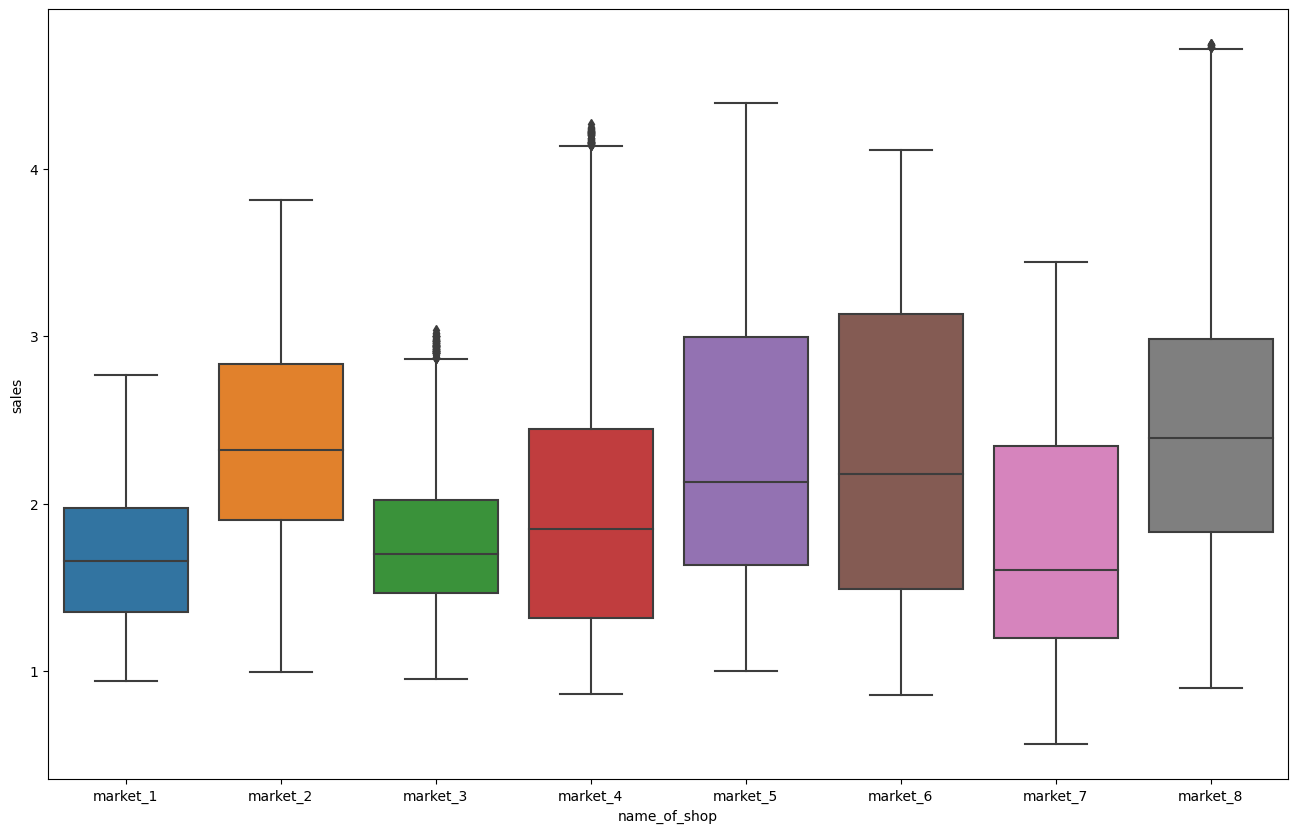

In [9]:
fig = plt.figure(figsize=(16, 10))
sns.boxplot(data=df, x='name_of_shop', y='sales');

Можно сделать вывод, что показатели продаж отличаются в зависимости от магазина, поэтому следует для каждого магазина делать отдельное предсказание.

Построим линейные графики продаж для каждого магазина в отдельности

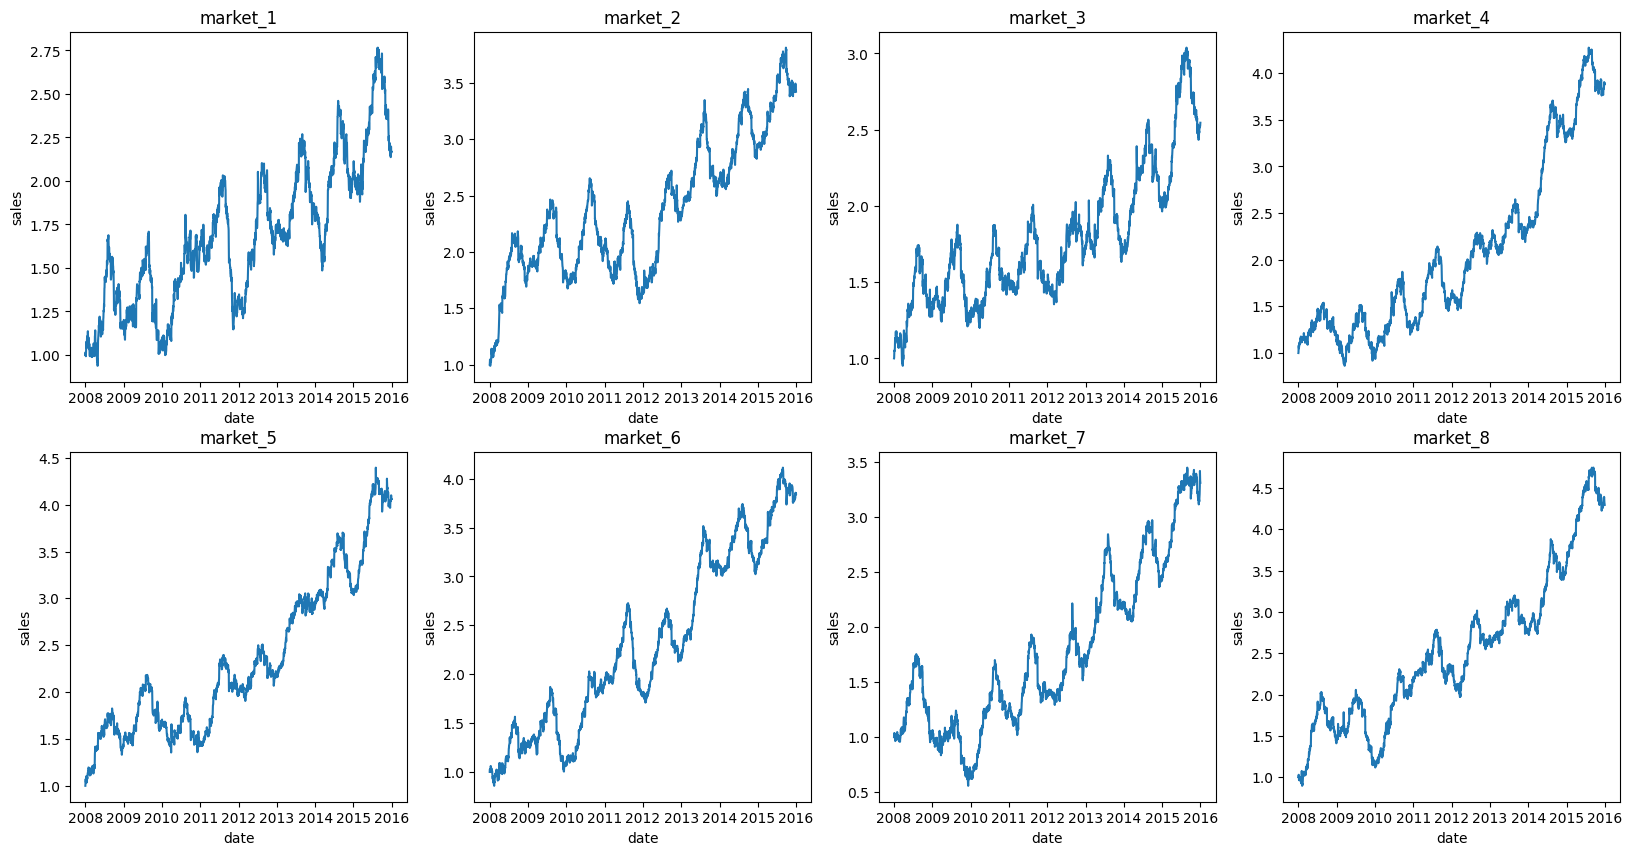

In [10]:
warnings.filterwarnings("ignore")

shops = df['name_of_shop'].unique()

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))

for index, name in enumerate(shops):
    sns.lineplot(data=df[df['name_of_shop'] == name], x='date', y='sales', ax=axs[index//4, index%4])
    axs[index//4, index%4].set_title(name)

Все графики имеют тренд на повышение и определенную сезонность, однако имеются некоторые различия. Для того чтобы провести более глубокий анализ возьмем данные по какому-нибудь одному магазину, например первому

In [11]:
market1 = df[df['name_of_shop'] == 'market_1'].drop('name_of_shop', axis=1)

Построим матрицу корреляций

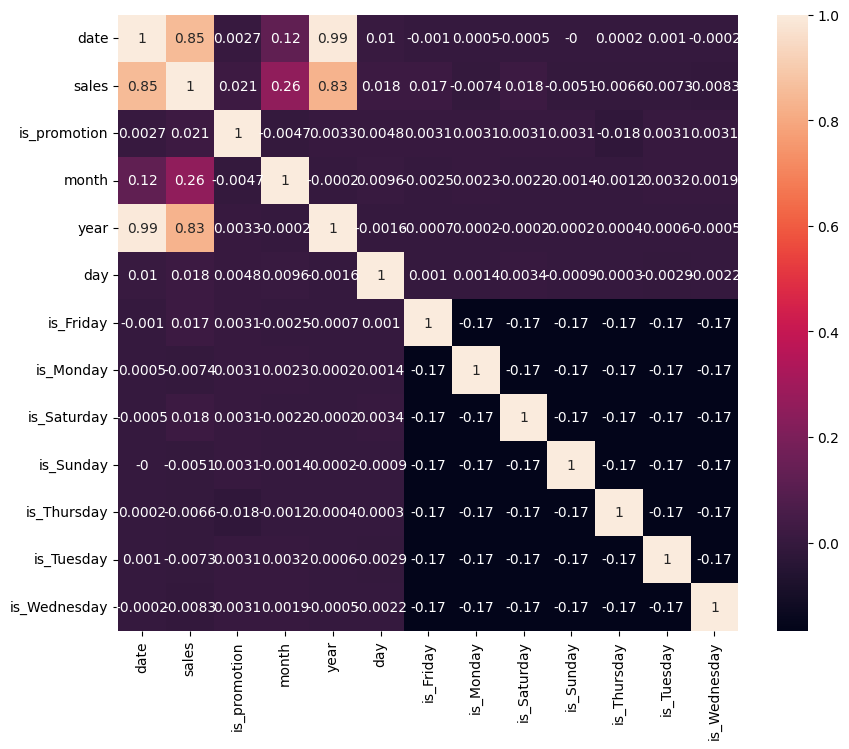

In [12]:
corr_matrix = market1.corr(method = 'pearson').apply(lambda x: round(x, 4))

fig = plt.figure(figsize = (10, 8))
sns.heatmap(corr_matrix, annot=True);

Матрица корреляций показывает, что продажи значимо зависят только от даты продажи, причем в большей степени от года, чем от месяца или дня. 

Попробуем обучить линейную регрессию на всех признаках и посмотрим на результат

In [13]:
X = market1.drop(['sales', 'date'], axis=1)
y = market1['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
print("koefs:")
pprint(list(zip(X.columns, list(linreg.coef_))))
print()

y_pred = linreg.predict(X_test)
print(f"RMSE is: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"R^2 is: {metrics.r2_score(y_test, y_pred)}")

koefs:
[('is_promotion', 0.1817000833399094),
 ('month', 0.03168929648210666),
 ('year', 0.15084483272331825),
 ('day', 0.0004581071960957795),
 ('is_Friday', 0.013871620672583773),
 ('is_Monday', -0.008388968472546157),
 ('is_Saturday', 0.005277816467061067),
 ('is_Sunday', 0.003069548186220569),
 ('is_Thursday', -0.01768697639734322),
 ('is_Tuesday', 0.009233113670715961),
 ('is_Wednesday', -0.005376154126689571)]

RMSE is: 0.21040942844108645
R^2 is: 0.7319586905050427


Результат не самый плохой. Теперь попробуем выбрать только нужные нам признаки

In [14]:
from sklearn.feature_selection import SelectKBest, f_regression

model = SelectKBest(score_func = f_regression)
results = model.fit(X_train, y_train )
pprint(list(zip(results.feature_names_in_, results.pvalues_)))

[('is_promotion', 0.4320575033590327),
 ('month', 7.160330330553612e-35),
 ('year', 0.0),
 ('day', 0.3417900379355622),
 ('is_Friday', 0.45302627946900376),
 ('is_Monday', 0.47965057579334747),
 ('is_Saturday', 0.45155863344403824),
 ('is_Sunday', 0.680611864544296),
 ('is_Thursday', 0.3122779997166866),
 ('is_Tuesday', 0.9790920958240082),
 ('is_Wednesday', 0.8358417527264735)]


Только 2 признака имеют p-value ниже 0,05. Посмотрим какой результат будет если обучить модель на этих 2 признаках.

In [15]:
X = market1[['year', 'month']]
y = market1['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

linreg = LinearRegression()
linreg.fit(X_train, y_train)
y_pred = linreg.predict(X_test)

print(f"RMSE is: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"R^2 is: {metrics.r2_score(y_test, y_pred)}")

RMSE is: 0.21049478209115435
R^2 is: 0.731741181768349


Результат ожидаемо не ухудшился, а значит на продажи влияет только дата.

Мы нашли ответ на первый вопрос - акции не имеют значительного влияния на объем продаж.

Теперь займемся предсказанием. Так как мы уже выяснили что на продажи влияет дата, то и анализировать продажи следует в качестве временных рядов. Возьмем для анализа данные по первому магазину

In [16]:
market1 = df[df['name_of_shop'] == 'market_1'].drop('name_of_shop', axis=1)
market1.set_index('date', inplace=True)
y = market1['sales']
market1.head()

,sales,is_promotion,month,year,day,is_Friday,is_Monday,is_Saturday,is_Sunday,is_Thursday,is_Tuesday,is_Wednesday
date,,,,,,,,,,,,
2008-01-02,1.000000,0,1,2008,2,False,False,False,False,False,False,True
2008-01-03,1.007594,0,1,2008,3,False,False,False,False,True,False,False
2008-01-04,1.015188,0,1,2008,4,True,False,False,False,False,False,False
2008-01-05,1.005475,0,1,2008,5,False,False,True,False,False,False,False
2008-01-06,0.995762,0,1,2008,6,False,False,False,True,False,False,False


Сделаем декомпозицию графика продаж, изменив масштаб графика с дневного на месячный, так как мы уже определили что день не имеет значимого влияния на показатели продаж, в отличие от года и месяца.

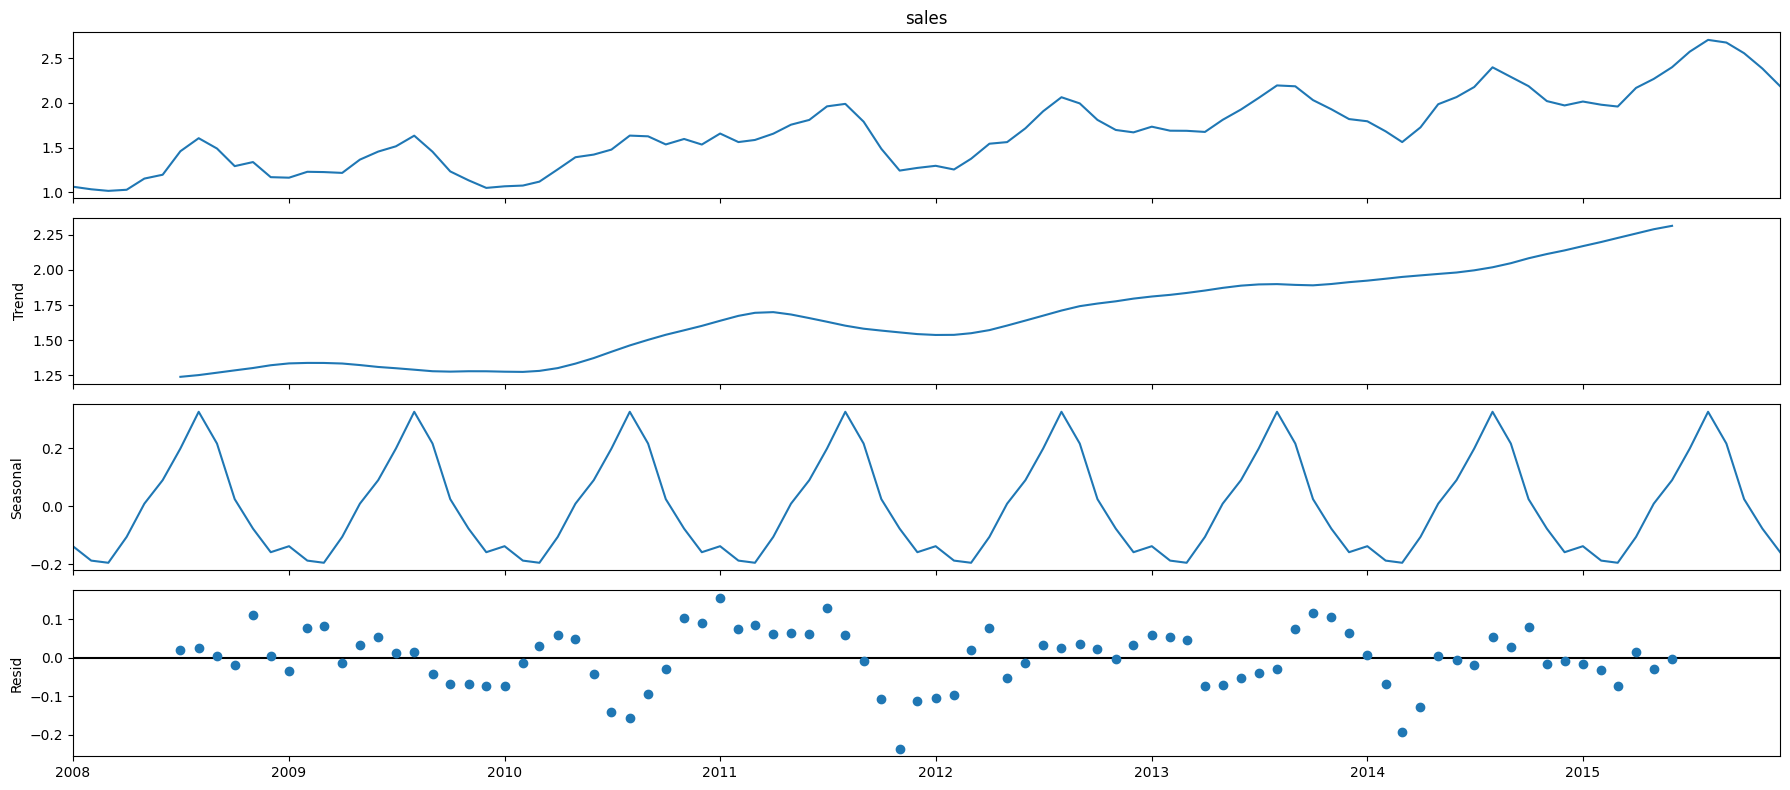

In [17]:
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(market1['sales'].resample('MS').mean(), model='additive')
fig = decomposition.plot()
plt.show()

Имеется ярко-выраженная сезонность - продажи растут с начала года и достигают пика летом, а минимума зимой. 

Для предсказвния будем использовать модель SARIMAX. Для начала подберем разные комбинации параметров для модели:

In [18]:
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print(seasonal_pdq)

[(0, 0, 0, 12), (0, 0, 1, 12), (0, 1, 0, 12), (0, 1, 1, 12), (1, 0, 0, 12), (1, 0, 1, 12), (1, 1, 0, 12), (1, 1, 1, 12)]


Теперь переберем в цикле все возможные комьинации параметров и выберем лучшую.

In [19]:
warnings.filterwarnings("ignore")

AIC = []
SARIMAX_model = []
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y, order = param, seasonal_order = param_seasonal,
                                            enforce_stationarity = False, enforce_invertibility = False)

            results = mod.fit()
            print(f'SARIMAX{param}x{param_seasonal} - AIC:{results.aic}', end = '\r')
            AIC.append(results.aic)
            SARIMAX_model.append([param, param_seasonal])
        except:
            continue

In [20]:
min_aic = min(AIC)
best_param, best_param_seasonal = SARIMAX_model[AIC.index(min(AIC))]

print(f'The smallest AIC is {min_aic} for model SARIMAX{best_param}x{best_param_seasonal}')

The smallest AIC is -13370.570137510591 for model SARIMAX(1, 1, 1)x(0, 0, 0, 12)


Обучим модель с заданными параметрами и проанализируем ее

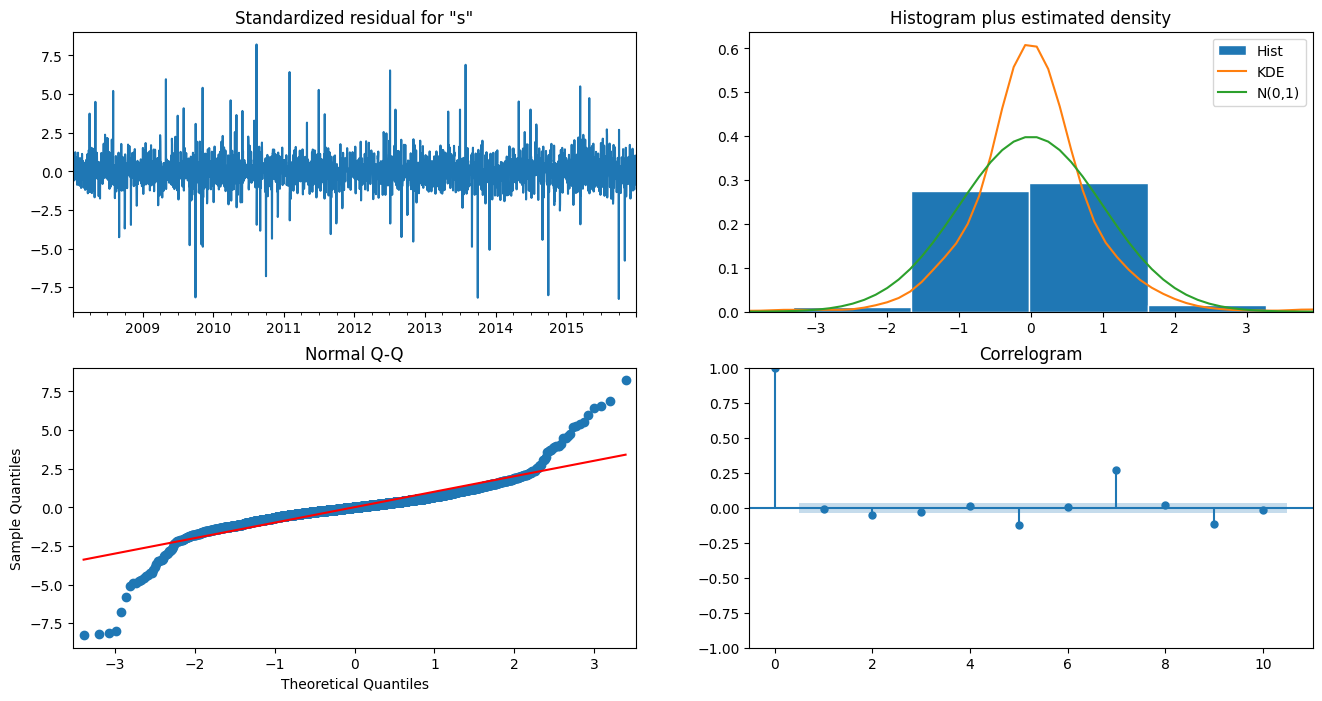

In [21]:
mod = sm.tsa.statespace.SARIMAX(y, order = best_param,
                                seasonal_order = best_param_seasonal,
                                enforce_stationarity = False, enforce_invertibility = False)

result = mod.fit()
result.plot_diagnostics(figsize=(16, 8))
plt.show()

In [22]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  sales   No. Observations:                 2921
Model:               SARIMAX(1, 1, 1)   Log Likelihood                6688.285
Date:                Sun, 08 Dec 2024   AIC                         -13370.570
Time:                        07:00:51   BIC                         -13352.634
Sample:                    01-02-2008   HQIC                        -13364.110
                         - 12-31-2015                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5024      0.076     -6.626      0.000      -0.651      -0.354
ma.L1          0.6413      0.072      8.859      0.000       0.499       0.783
sigma2         0.0006   5.55e-06    107.770      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.44   Jarque-Bera (JB):             24373.12
Prob(Q):                              0.51   Prob(JB):                         0.00
Heteroskedasticity (H):               1.04   Skew:                            -0.27
Prob(H) (two-sided):                  0.54   Kurtosis:                        17.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Несмотря на некоторые несоответствия остатки все таки рампределены нормально, что подтверждает значение Ljung-Box (L1) (Q):	0.44, которое должно быть больше 0.05

Сделаем прогноз для 2015 года и отобразим его на графике вместо данных которые у нас есть за 2015 год:

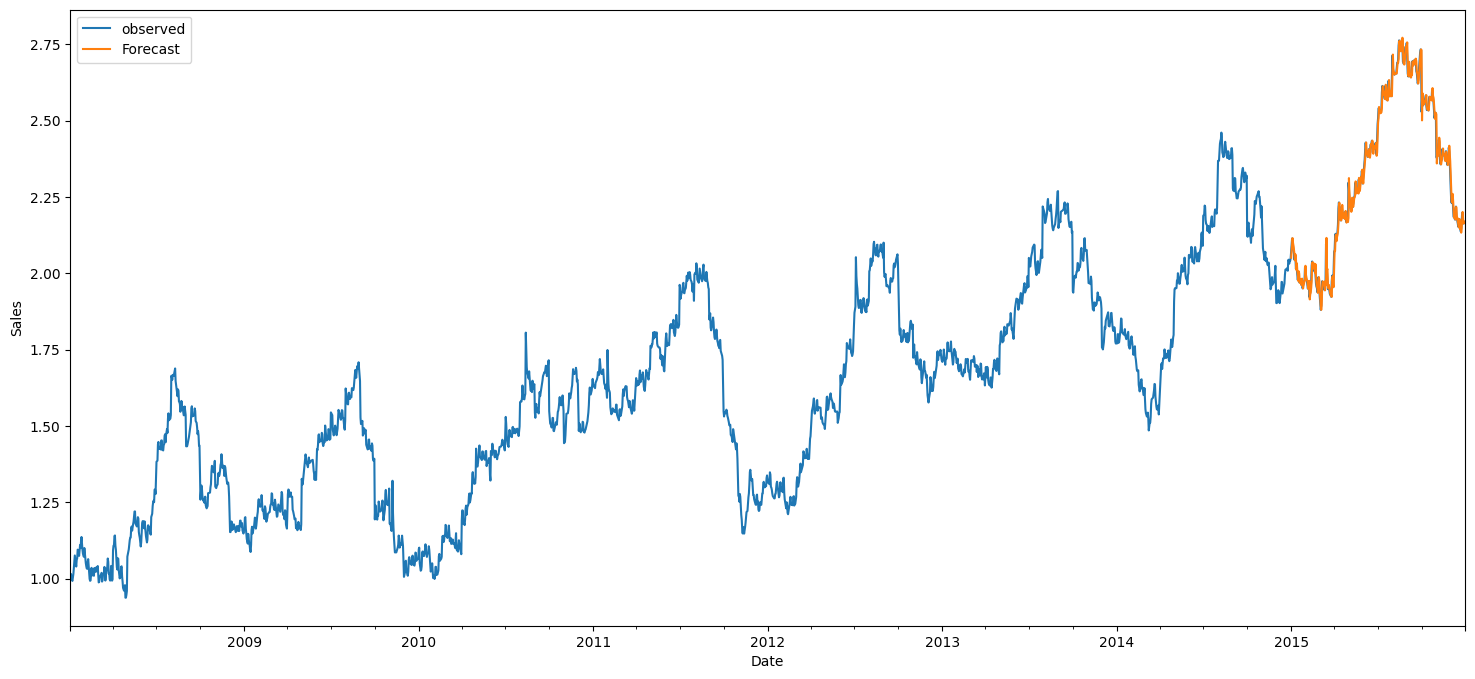

In [23]:
pred = result.get_prediction(start = pd.to_datetime('2015-01-01'), dynamic = False)
ax = y[:'2015'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

А теперь вычислим ошибку для данного прогноза

In [24]:
y_pred = pred.predicted_mean
y_truth = y['2015':]
print(f'The RMSE is {round(np.sqrt(metrics.mean_squared_error(y_truth, y_pred)), 4)}')
print(f"R^2 is: {round(metrics.r2_score(y_truth, y_pred), 4)}")

The RMSE is 0.0262
R^2 is: 0.9898


Теперь сделаем предсказание для 2016 и 2017 года и посмотрим на график

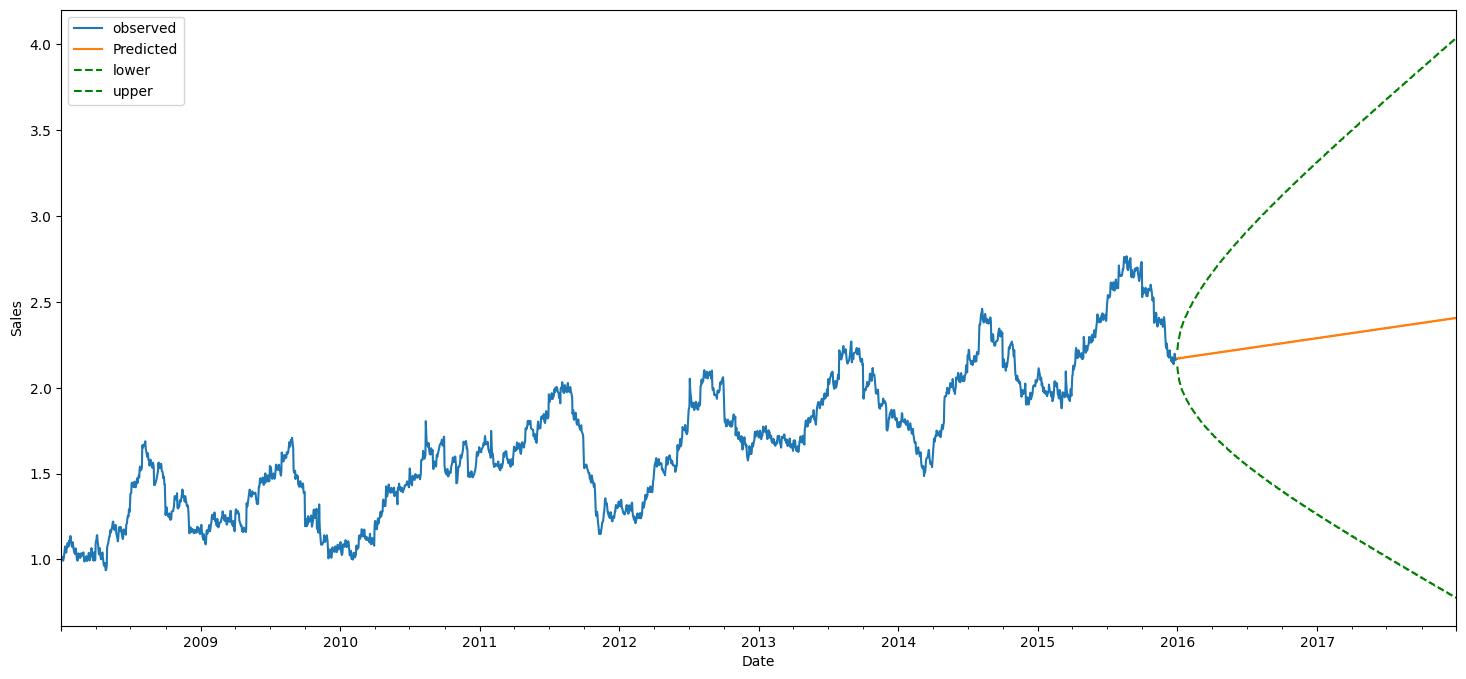

In [25]:
pred = results.get_prediction(start='2016-01-01', end='2017-12-31')
ax = y.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Predicted')
pred.conf_int()['lower sales'].plot(ax=ax, label='lower', color="green", linestyle="--",)
pred.conf_int()['upper sales'].plot(ax=ax, label='upper', color="green", linestyle="--",)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

Как видим модель SARIMAX на длительные промежутки времени строит очень размытый прогноз, причем не учитывая сезонность.

Попробуем построить прогноз другими методами, например при помощи случайного леса.

Сначала посмотрим насколько хороша модель случайного леса по метрикам

In [26]:
X = market1.drop('sales', axis=1)
y = market1['sales']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state = 42)

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

print(f"RMSE is: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f"R^2 is: {metrics.r2_score(y_test, y_pred)}")

RMSE is: 0.023304630049217834
R^2 is: 0.9967118186340478


Рандомный лес демонстрирует хорошие показатели. Попробуем сделать предсказание. В качестве тренировочной выборки будем использовать полностью датасет с которым работаем, а в качестве тестовой выборки загрузить специальный датасет

In [27]:
X_test = pd.read_csv('advert_test.csv')
X_test = X_test[['date', 'market_1']].rename(columns={'market_1' : 'is_promotion'})
X_test['date'] = pd.to_datetime(X_test['date'])
X_test['day'] = X_test['date'].dt.day
X_test['month'] = X_test['date'].dt.month
X_test['year'] = X_test['date'].dt.year
X_test.set_index('date', inplace=True)
X_test = X_test[['day', 'month', 'year', 'is_promotion']]
X_test.head()

,day,month,year,is_promotion
date,,,,
2016-01-01,1,1,2016,0
2016-01-02,2,1,2016,0
2016-01-03,3,1,2016,0
2016-01-04,4,1,2016,0
2016-01-05,5,1,2016,0


Сделаем прогноз и построим графики

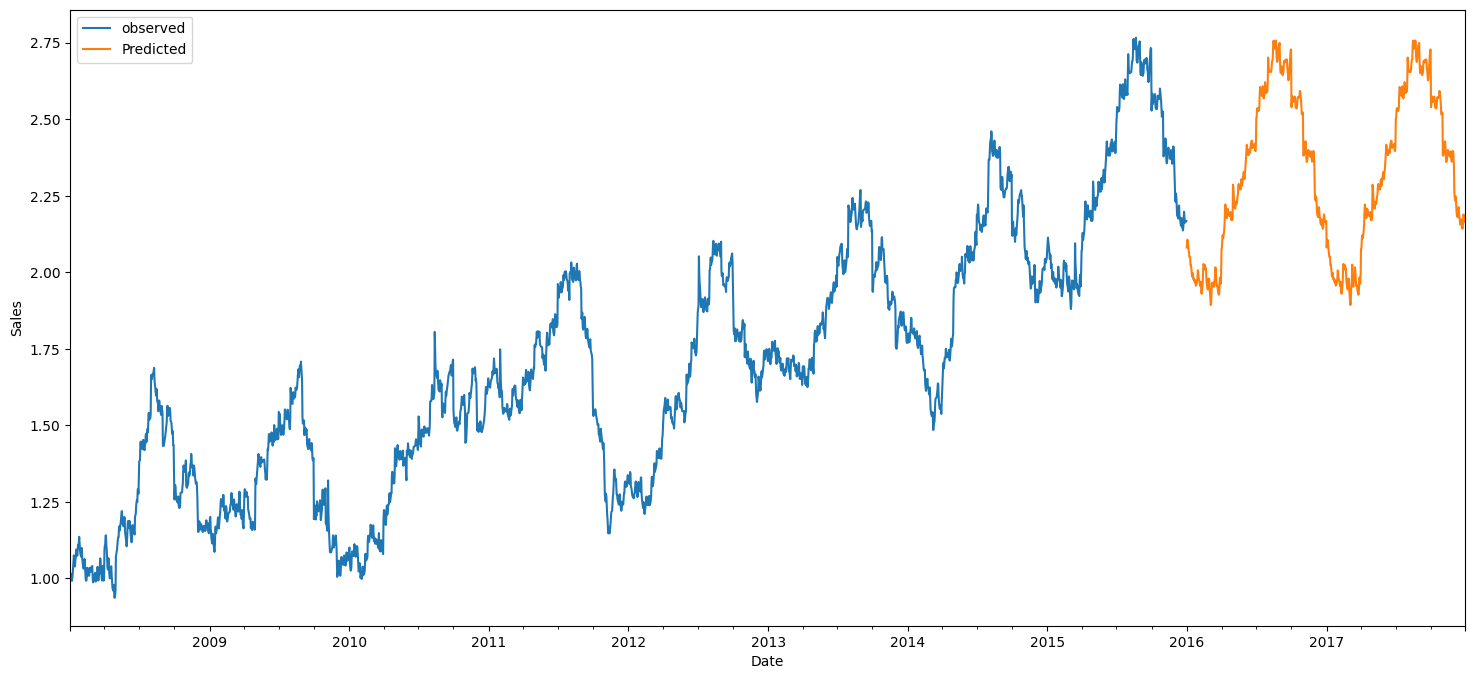

In [28]:
X_train = market1[['day', 'month', 'year', 'is_promotion']]
y_train = market1['sales']

rf = RandomForestRegressor(random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
y_pred = pd.Series(y_pred, X_test.index)

ax = y_train.plot(label='observed')
y_pred.plot(ax=ax, label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

Модель уловила сезонность, но не учла тренд. Попробуем прибавить значения, чтобы учесть тренд в наших рассчетах.

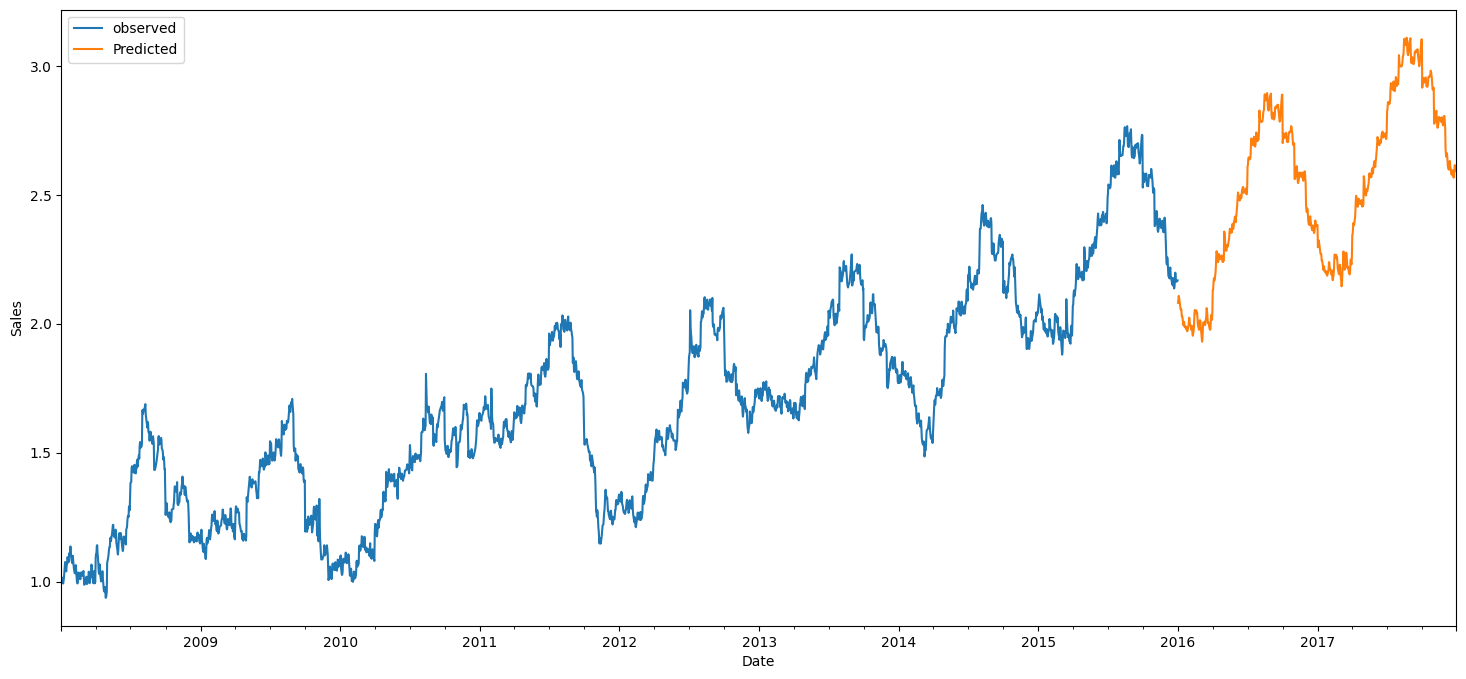

In [29]:
# Вычислим среднюю разницу продаж за последние 2 года
val = market1[market1['year'] == 2015]['sales'].mean() - market1[market1['year'] == 2013]['sales'].mean()
# Создадим вектор значений от 0 до значения, вычисленного выше
values = np.linspace(0, val, y_pred.shape[0])
# Прибавим к предыдущему предсказанию вектор значений
new_pred = y_pred + values

# Построим график с новыми значениями
ax = y_train.plot(label='observed')
new_pred.plot(ax=ax, label='Predicted')
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

Выглядит гораздо лучше!

А теперь по заданию нужно сделать предсказание для всех магазинов. Поэтому сделаем это, используя метод случайного леса с поправкой на тренд.

В первую очередь подготовым датасет с тестовой выборкой:

In [30]:
advert_test = pd.read_csv('advert_test.csv')
advert_test = advert_test.melt(id_vars='date', var_name='name_of_shop', value_name='is_promotion')
advert_test['date'] = pd.to_datetime(advert_test['date'])
advert_test['day'] = advert_test['date'].dt.day
advert_test['month'] = advert_test['date'].dt.month
advert_test['year'] = advert_test['date'].dt.year
advert_test.set_index('date', inplace=True)
advert_test.head()

,name_of_shop,is_promotion,day,month,year
date,,,,,
2016-01-01,market_1,0,1,1,2016
2016-01-02,market_1,0,2,1,2016
2016-01-03,market_1,0,3,1,2016
2016-01-04,market_1,0,4,1,2016
2016-01-05,market_1,0,5,1,2016


А теперь проидемся в цикле по магазинам и сделаем предсказание для каждого

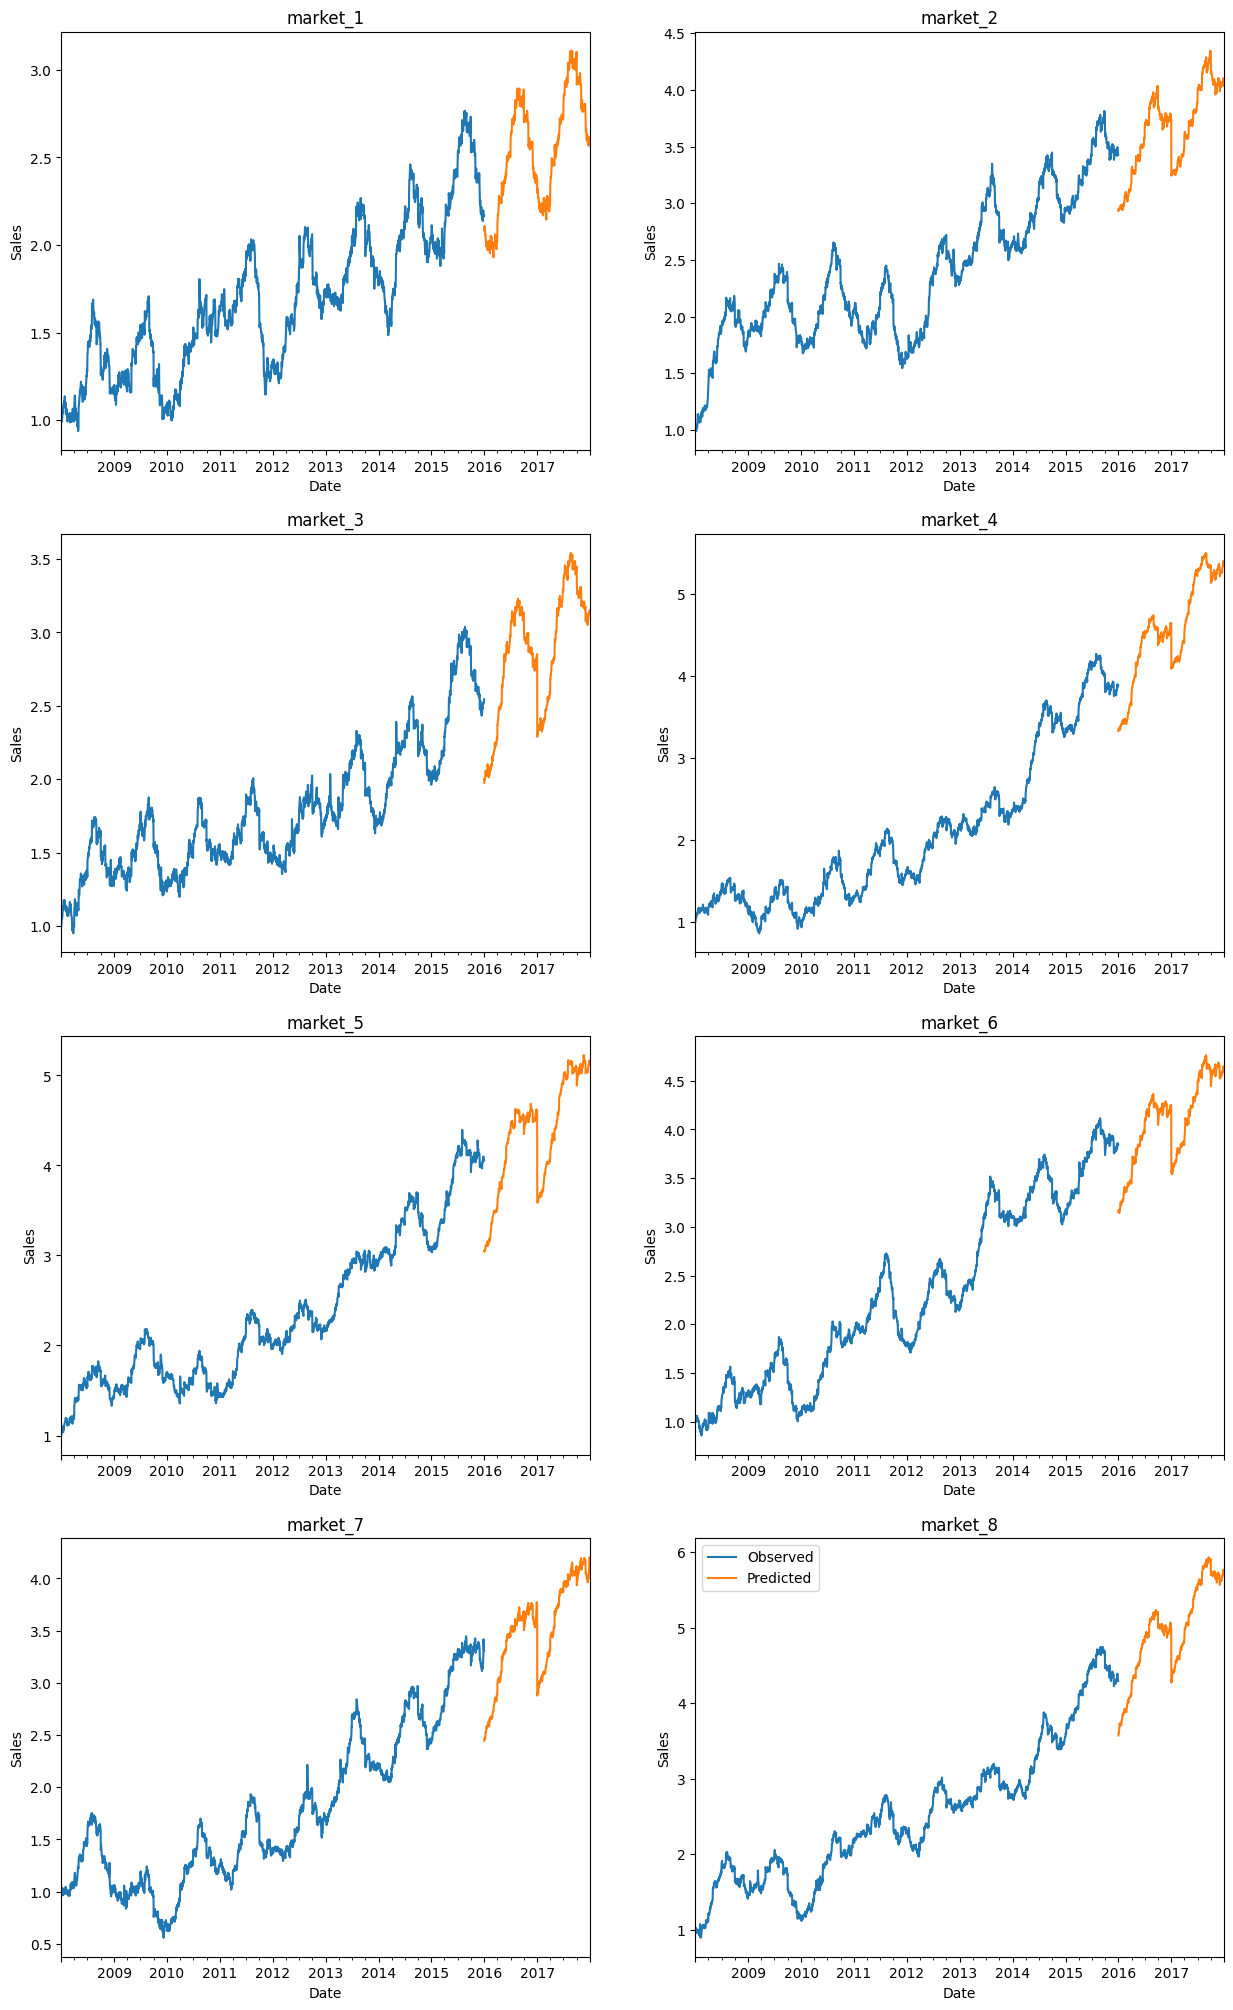

In [31]:
# Построим плоскость для визуализации
fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(15, 25))

# Создадим список, в него будем записывать результаты для каждого магазина
result = []

for i, shop in enumerate(shops):
    # Выделяем выборки для нашего магазина
    current_shop = df[df['name_of_shop'] == shop].drop('name_of_shop', axis=1)
    current_shop.set_index('date', inplace=True)
    X_train = current_shop[['is_promotion', 'day', 'month', 'year']]
    y_train = current_shop['sales']
    X_test = advert_test[advert_test['name_of_shop'] == shop].drop('name_of_shop', axis=1)
    
    # Обучаем модель
    model = RandomForestRegressor(random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred = pd.Series(y_pred, X_test.index)
    
    # Добавляем коррректирующее значение к предсказанию
    val = current_shop[current_shop['year'] == 2015]['sales'].mean() \
        - current_shop[current_shop['year'] == 2013]['sales'].mean()
    values = np.linspace(0, val, y_pred.shape[0])
    y_pred = y_pred + values 
    
    # Добавляем вектор с ответами в список с результатом
    result.append(y_pred)
    
    # Добавляем график по конкретному магазину в ячейку на плоскости
    y_train.plot(ax=axs[i//2, i%2], label='Observed')
    y_pred.plot(ax=axs[i//2, i%2], label='Predicted')
    axs[i//2, i%2].set_xlabel('Date')
    axs[i//2, i%2].set_ylabel('Sales')
    axs[i//2, i%2].set_title(shop)
    
plt.legend()
plt.show()

In [32]:
deploy = pd.DataFrame(dict(zip(shops, result)))
deploy.head()

,market_1,market_2,market_3,market_4,market_5,market_6,market_7,market_8
date,,,,,,,,
2016-01-01,2.081149,2.934049,1.976712,3.330814,3.046160,3.155506,2.445587,3.574339
2016-01-02,2.092525,2.951347,1.997847,3.355558,3.051343,3.172642,2.465915,3.592842
2016-01-03,2.107970,2.948719,2.006052,3.356673,3.058393,3.171083,2.468397,3.609324
2016-01-04,2.100260,2.939669,1.996712,3.348407,3.047659,3.164991,2.464233,3.604365
2016-01-05,2.089555,2.938324,1.999552,3.349997,3.046606,3.157177,2.466128,3.612403


In [33]:
deploy.to_csv('deploy.csv')